# 1. Import Essential Libraries and Packages

In [1]:
import numpy as np # trigonometric/logarithmic and R^2 functions Package
import matplotlib.pyplot as plt # Plot function Package
from scipy.integrate import solve_ivp # ODE solver 
import csv # Package to read CSV files

# 2. Import Experimental Data

In [3]:
# Generation of lists to store raw experimental data from file (ensure file is stored as CSV otherwise raw data will not be properly stored)
t_exp_raw = []
C1_exp_raw = []
C2_exp_raw = []
theta1_exp_raw = []
theta2_exp_raw = []
thetaho_exp_raw = []
thetahm_exp_raw = []

with open('Validation data for two CSTR reactors in series.csv', newline = '') as csvfile:
    csv_reader = csv.reader((row.replace('\0', '') for row in csvfile), delimiter = ',') # Read CSV file
    
    # Collection of raw experimental data from CSV file
    for row in csv_reader:
        t_exp_raw.append(row[6])
        C1_exp_raw.append(row[7])
        C2_exp_raw.append(row[8])
        theta1_exp_raw.append(row[9])
        theta2_exp_raw.append(row[10])
        thetaho_exp_raw.append(row[11])
        thetahm_exp_raw.append(row[12])

## 2.1. Cleaning Data

In [5]:
# Clean up: Removal of headers and other unwanted information from the 1st 5 rows of the raw experimental data
for i in range(5):
    t_exp_raw.pop(0)
    C1_exp_raw.pop(0)
    C2_exp_raw.pop(0)
    theta1_exp_raw.pop(0)
    theta2_exp_raw.pop(0)
    thetaho_exp_raw.pop(0)
    thetahm_exp_raw.pop(0)

In [7]:
# Clean up: Removal of extra spaces below the raw experimental data to enable convertion of string data to float type
while "" in t_exp_raw:
    t_exp_raw.remove("")     
while "" in C1_exp_raw:
    C1_exp_raw.remove("")   
while "" in C2_exp_raw:
    C2_exp_raw.remove("")
while "" in theta1_exp_raw:
    theta1_exp_raw.remove("")    
while "" in theta2_exp_raw:
    theta2_exp_raw.remove("")
while "" in thetaho_exp_raw:
    thetaho_exp_raw.remove("")
while "" in thetahm_exp_raw:
    thetahm_exp_raw.remove("")

## 2.2. Data Transformation

In [9]:
# Convertion of cleaned experimental data from string type to float type and store cleaned experimental data in new lists
t_exp = [float(x) for x in t_exp_raw]
C1_exp = [float(x) for x in C1_exp_raw]
C2_exp = [float(x) for x in C2_exp_raw]
theta1_exp = [float(x) for x in theta1_exp_raw]
theta2_exp = [float(x) for x in theta2_exp_raw]
thetaho_exp = [float(x) for x in thetaho_exp_raw]
thetahm_exp = [float(x) for x in thetahm_exp_raw]

# 3. Mathematical Modelling

## 3.1. Modelling: System Inputs

In [11]:
# System Inputs (as per system inputs used for to generate experimental data)

M1 = 300 # mass in CSTR 1 (kg)
M2 = 500 # mass in CSTR 2 (kg) 
cp = 4182 # specific heat capacity of reactant (J/kg.degC) (Closely approximated by water)
thetahi = 80 # temperature of jacket fluid in (degC)
thetaF = 20 # temperature of feed fluid (degC)
E = 50887.87168 # activation energy (J/mol) (Determined as per derivations in sheet "kref and Ea" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
R = 8.314 # ideal gas constant (J/mol.K)
F = 16.7 / 60 # flowrate between CSTRs (kg/s)
q = 50 / 60 # flowrate of heating fluid in jackets (kg/s)
cph = 4182 # specific heat capacity of heating fluid (J/kg.degC) (heating fluid = water)
CF = 1.2 # feed concentration to CSTR 1 (mol/kg)
A1 = 2.24683565 # Surface area of heat transfer between jacket 1 and CSTR1 (m^2) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
A2 = 3.149478051 # Surface area of heat transfer between jacket 1 and CSTR1 (m^2) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
UA1 = 4373.635737 # Average overall heat flux of jacket to CSTR1 (W/degC) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
UA2 = 6180.284147 # Average overall heat flux of jacket to CSTR2 (W/degC) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
U1 = UA1 / A1 # Overall heat transfer coefficient of jacket to CSTR1 (W/m^2.degC)
U2 = UA2 / A2 # Overall heat transfer coefficient of jacket to CSTR1 (W/m^2.degC)
n = 1 # Order of reaction (unitless) (Determined as per derivations in sheet "kref and Ea" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
thetaref = 25 # Reference temperature for rate constant (degC)
kref = 2.7431613E-04 # Rate constant at thetaref (s^-1) (Determined as per derivations in sheet "kref and Ea" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")

SI = (M1, M2, cp, thetahi, thetaF, E, R, F, q, cph, CF, U1, U2, A1, A2, n, thetaref, kref) # list of system inputs to be used as arguements for the defined ODE function

## 3.2. Modelling: Algebraic Equations and ODEs Function

In [13]:
# Define algebraic equations and ODEs function
def ODEs (t,y, M1, M2, cp, thetahi, thetaF, E, R, F, q, cph, CF, U1, U2, A1, A2, n, thetaref, kref):
    # Assignment of dependent variables to dependent variable list items
    theta1 = y[0]
    theta2 = y[1]
    C1 = y[2]
    C2 = y[3]
    # Algebraic Equations
    thetahm = theta2 + ((thetahi - theta2) * np.exp((-U2 * A2)/(q * cph))) # assuming no heat loss from jacket to ambient (degC)
    thetaho = theta1 + ((thetahm - theta1) * np.exp((-U1 * A1)/(q * cph))) # assuming no heat loss from jacket to ambient (degC)
    dthetalm1 = (thetahm - thetaho) / np.log((thetahm - theta1)/(thetaho - theta1)) # LMTD between CSTR 1 and jacket 1 (degC)
    dthetalm2 = (thetahi - thetahm) / np.log((thetahi - theta2)/(thetahm - theta2)) # LMTD between CSTR 2 and jacket 2 (degC)
    k1 = kref * np.exp(E/R * ((1 / (thetaref + 273.15)) - (1 / (theta1 + 273.15)))) # rate constant for reaction in CSTR 1 (s^-1)
    k2 = kref * np.exp(E/R * ((1 / (thetaref + 273.15)) - (1 / (theta2 + 273.15)))) # rate constant for reaction in CSTR 2 (s^-1)
    # ODEs
    dtheta1_dt = (F * cp * (thetaF - theta1) + U1 * A1 * dthetalm1) / (M1 * cp) # rate of fluid temperature change in CSTR 1 (degC/s)
    dtheta2_dt = (F * cp * (theta1 - theta2) + U2 * A2 * dthetalm2) / (M2 * cp) # rate of fluid temperature change in CSTR 2 (degC/s)
    dC1_dt = (F * (CF - C1) - (k1 * (C1 ** n) * M1)) / M1 # rate of change in reactant concentration in CSTR 1 (mol/kg.s)
    dC2_dt = (F * (C1 - C2) - (k2 * (C2 ** n) * M2)) / M2 # rate of change in reactant concentration in CSTR 1 (mol/kg.s)
    return [dtheta1_dt, dtheta2_dt, dC1_dt, dC2_dt]

## 3.3. Modelling: Simulation Timeframe

In [15]:
# Declaration of a time vector (timeframe of simulation)
t_start = 0 # simulation start time (s)
t_end = 60*60 # simulation end time (s)
t_interval = int(t_end / 1 + 1) # Number of intervals of integration for simulation
t = np.linspace(t_start, t_end, t_interval) # time vector

## 3.4. Modelling: Initial Conditions

In [17]:
# Initial conditions (as per initial conditions used for to generate experimental data)
theta1i = 20 # where theta1 = theta1i at t = 0 (degC)
theta2i = 20 # where theta2 = theta2i at t = 0 (degC)
C1i = 0 # where C1 = C1i at t = 0 (mol/kg) (water initially in tanks)
C2i = 0 # where C2 = C2i at t = 0 (mol/kg) (water initially in tanks)

y0 = [theta1i, theta2i, C1i, C2i] # list of initial dependant variables required for integration

# 4. Mathematical Model Checking

## 4.1. Model Checking: Numerical Solution

In [19]:
# Unpacking and integration of dependent variables
dD_dt = solve_ivp(ODEs, [t_start,t_end], y0, t_eval = t, method = 'RK45', args = SI) # Numerical solution of ODEs with solve_ivp's 'RK45' method (Explicit Runge-Kutta method of order 5(4)) at a relative tolerance of 1e-3


theta1 = dD_dt.y[0] # assign list item 0 to list theta1 
theta2 = dD_dt.y[1] # assign list item 1 to list theta2
C1 = dD_dt.y[2] # assign list item 2 to list C1
C2 = dD_dt.y[3] # assign list item 3 to list C2

## 4.2. Model Checking: Relative Tolerance Analysis

In [21]:
# Unpacking of dependent variables
dD_dt = solve_ivp(ODEs, [t_start,t_end], y0, t_eval = t, method = 'RK45', rtol = 1e-4, args = SI) # Numerical solution of ODEs with solve_ivp's 'RK45' method (Explicit Runge-Kutta method of order 5(4)) at a relative tolerance of 1e-4

theta1R4 = dD_dt.y[0] # assign list item 0 to list theta1R4
theta2R4 = dD_dt.y[1] # assign list item 1 to list theta2R4
C1R4 = dD_dt.y[2] # assign list item 2 to list C1R4
C2R4 = dD_dt.y[3] # assign list item 2 to list C2R4

### 4.2.1. Model Checking: Relative Tolerance Analysis Visualisation

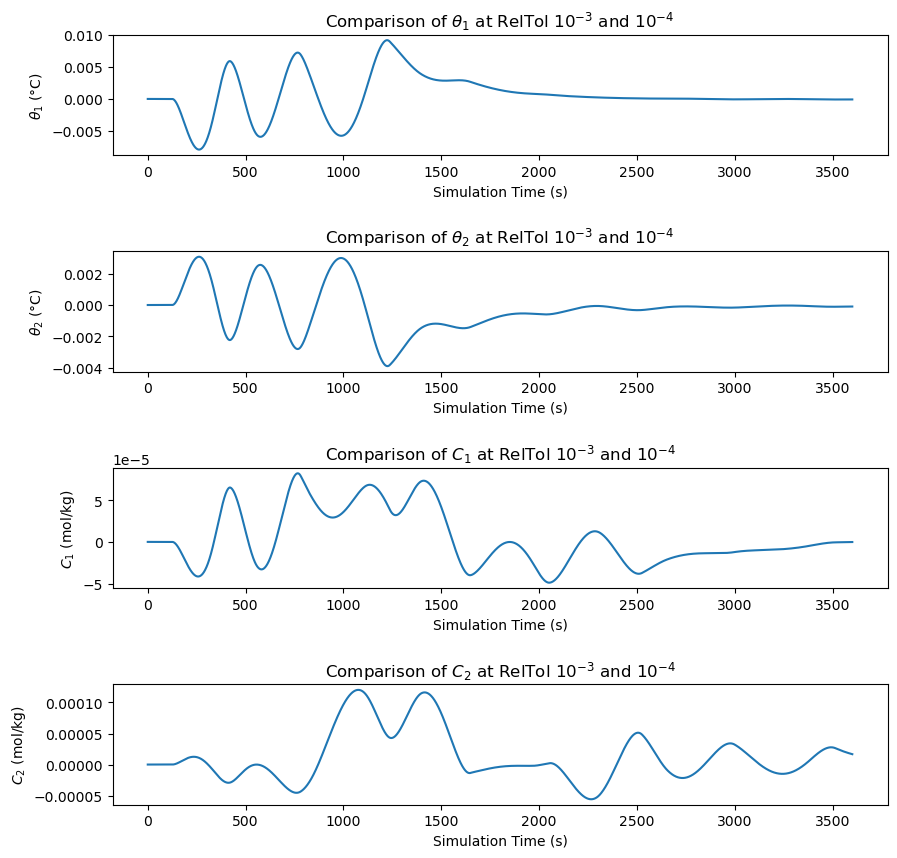

In [23]:
# Generation of comparison plot of dependent variables against simulation time at RelTol 1e-3 and 1e-4
plt.figure(figsize = (10, 10)) # Plot size
plt.subplots_adjust(hspace = 0.8) # Adjust height interval between plots to adequately display x-axis titles

plt.subplot(411) # Assignment of plot space
plt.title(r"Comparison of $\theta_{1}$ at RelTol $10^{-3}$ and $10^{-4}$") # Plot title
plt.plot(t, theta1-theta1R4) # Plot of theta1 against simulation time
plt.ylabel(r"$\theta_{1}$ ($\degree$C)") # y-axis label
plt.xlabel("Simulation Time (s)") # x-axis label

plt.subplot(412) # Assignment of plot space 
plt.title(r"Comparison of $\theta_{2}$ at RelTol $10^{-3}$ and $10^{-4}$") # Plot title
plt.plot(t, theta2-theta2R4) # Plot of theta2 against simulation time
plt.ylabel(r"$\theta_{2}$ ($\degree$C)") # y-axis label
plt.xlabel("Simulation Time (s)") # x-axis label

plt.subplot(413) # Assignment of plot space
plt.title(r"Comparison of $C_{1}$ at RelTol $10^{-3}$ and $10^{-4}$") # Plot title
plt.plot(t, C1-C1R4) # Plot of C1 against simulation time
plt.ylabel("$C_{1}$ (mol/kg)") # y-axis label
plt.xlabel("Simulation Time (s)") # x-axis label

plt.subplot(414) # Assignment of plot space
plt.title(r"Comparison of $C_{2}$ at RelTol $10^{-3}$ and $10^{-4}$") # Plot title
plt.plot(t, C2-C2R4) # Plot of C2 against simulation time
plt.ylabel("$C_{2}$ (mol/kg)") # y-axis label
plt.xlabel("Simulation Time (s)") # x-axis label

plt.show()                        # Display plot

Range of theta1, theta2, C1 and C2 are much lower in magnitude as compared to respective ranges within simulation period, thus relative tolerance of 10-3 is suitable to be used for the modelling.

Relative tolerance of ODE at 10-3 is suitable to ensure there are no numerical errors as a result of inappropriate timestep of integration

## 4.3. Model Checking: Analytical Method (Theta 1)

Special Scenario - F = 0 to uncouple theta2 from theta1's ODE equation

### 4.3.1. Analytical Method (Theta 1) System Inputs

In [25]:
# System Inputs (as per system inputs used for to generate experimental data modified for F = 0)
M1_AMT1 = 300 # mass in CSTR 1 (kg)
M2_AMT1 = 500 # mass in CSTR 2 (kg) 
cp_AMT1 = 4182 # specific heat capacity of reactant (J/kg.degC) (Closely approximated by water)
thetahi_AMT1 = 80 # temperature of jacket fluid in (degC)
thetaF_AMT1 = 20 # temperature of feed fluid (degC)
E_AMT1 = 50887.87168 # activation energy (J/mol) (Determined as per derivations in sheet "kref and Ea" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
R_AMT1 = 8.314 # ideal gas constant (J/mol.K)
F_AMT1 = 0 # flowrate between CSTRs (kg/s)
q_AMT1 = 50 / 60 # flowrate of heating fluid in jackets (kg/s)
cph_AMT1 = 4182 # specific heat capacity of heating fluid (J/kg.degC) (heating fluid = water)
CF_AMT1 = 1.2 # feed concentration to CSTR 1 (mol/kg)
A1_AMT1 = 2.24683565 # Surface area of heat transfer between jacket 1 and CSTR1 (m^2) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
A2_AMT1 = 3.149478051 # Surface area of heat transfer between jacket 1 and CSTR1 (m^2) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
UA1_AMT1 = 4373.635737 # Average overall heat flux of jacket to CSTR1 (W/degC) (value set small/ close to 0 as 0 will result in 0/0 errors)
UA2_AMT1 = 6180.284147 # Average overall heat flux of jacket to CSTR2 (W/degC) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
U1_AMT1 = UA1_AMT1 / A1_AMT1 # Overall heat transfer coefficient of jacket to CSTR1 (W/m^2.degC)
U2_AMT1 = UA2_AMT1 / A2_AMT1 # Overall heat transfer coefficient of jacket to CSTR1 (W/m^2.degC)
n_AMT1 = 1 # Order of reaction (unitless) (Determined as per derivations in sheet "kref and Ea" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
thetaref_AMT1 = 25 # Reference temperature for rate constant (degC)
kref_AMT1 = 2.7431613E-04 # Rate constant at thetaref (s^-1) (Determined as per derivations in sheet "kref and Ea" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")

SI_AMT1 = (M1_AMT1, M2_AMT1, cp_AMT1, thetahi_AMT1, thetaF_AMT1, E_AMT1, R_AMT1, F_AMT1, q_AMT1, cph_AMT1, CF_AMT1, U1_AMT1, U2_AMT1, A1_AMT1, A2_AMT1, n_AMT1, thetaref_AMT1, kref_AMT1) # list of system inputs to be used as arguements for the defined ODE function

### 4.3.2. Analytical Method (Theta 1) Generation

In [27]:
# Theta1 values based on analytical method
theta1_AMT1 = [] # creation of list
w = (q_AMT1 * cph_AMT1)/(M1_AMT1 * cp_AMT1) # sub equation w for ease of modelling
x = U1_AMT1 * A1_AMT1 / (q_AMT1 * cph_AMT1) # sub equation x for ease of modelling
y = U2_AMT1 * A2_AMT1 / (q_AMT1 * cph_AMT1) # sub equation y for ease of modelling
z = (1 - np.exp(-y)) * q_AMT1 * cph_AMT1 / (M2_AMT1 * cp_AMT1) # sub equation z for ease of modelling
for i in t:
    theta1_AMT1_i = thetahi_AMT1 + ((w / ((w * (1 - np.exp(-x))) -z)) * np.exp(-z * i) * (theta2i - thetahi_AMT1) * (1 - np.exp(-y)) * (1 - np.exp(-x))) + 104.28862446095164 * np.exp(-(w * (1 - np.exp(-x))) * i) # Analytical Solution for theta1 at F = 0
    theta1_AMT1.append(theta1_AMT1_i) # theta 1 analytical solution list 

    
# Unpacking and integration of dependent variables
dD_dt_F = solve_ivp(ODEs, [t_start,t_end], y0, t_eval = t, method = 'RK45', args = SI_AMT1) # Numerical solution of ODEs with solve_ivp's 'RK45' method (Explicit Runge-Kutta method of order 5(4)) at a relative tolerance of 1e-3
theta1_AMT1_ODE = dD_dt_F.y[0] # assign of list item 1 to list theta2 

### 4.3.3. Model Checking: Analytical Method (Theta 1) Visualisation

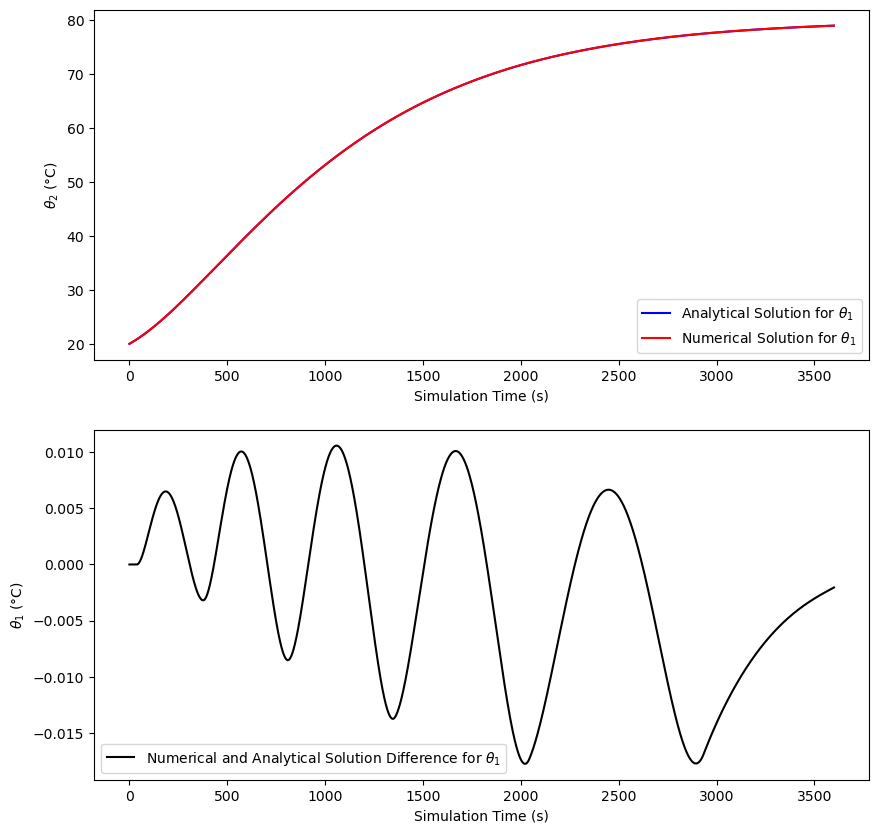

In [29]:
# Generation of plot of dependent variables against simulation time
plt.figure(figsize = (10, 10)) # Plot size

plt.subplot(211) # Assignment of plot space
plt.plot(t, theta1_AMT1, 'b', label = r"Analytical Solution for $\theta_{1}$") # Plot of numerical theta1 against simulation time
plt.plot(t, theta1_AMT1_ODE, 'r', label = r"Numerical Solution for $\theta_{1}$") # Plot of analytical theta1 against simulation time
plt.legend(loc = "lower right") # Plot legend location
plt.ylabel(r"$\theta_{2}$ ($\degree$C)") # y-axis label 
plt.xlabel("Simulation Time (s)") # x-axis label 

plt.subplot(212) # Assignment of plot space to plot of theta1 against simulation time
plt.plot(t, theta1_AMT1-theta1_AMT1_ODE, 'k', label = r"Numerical and Analytical Solution Difference for $\theta_{1}$") # Plot of difference in numerical and analytical theta1 against simulation time
plt.legend(loc = "lower left") # Plot legend location
plt.ylabel(r"$\theta_{1}$ ($\degree$C)") # y-axis label 
plt.xlabel("Simulation Time (s)") # x-axis 

plt.show() # Display plot

Range of difference between theta1 values obtained via numerical and analytical solutions are very insignificant in magnitude and thus, ODE of theta 1 is adequate to describe the system and is mathematically consistent and free from errors 

## 4.4. Model Checking: Analytical Method (Theta 2)

Special Scenario - F = 0 to uncouple theta1 from theta2's ODE equation

### 4.4.1. Analytical Method (Theta 2) System Inputs

In [31]:
# System Inputs (as per system inputs used for to generate experimental data modified for F = 0)
M1_AMT2 = 300 # mass in CSTR 1 (kg)
M2_AMT2 = 500 # mass in CSTR 2 (kg) 
cp_AMT2 = 4182 # specific heat capacity of reactant (J/kg.degC) (Closely approximated by water)
thetahi_AMT2 = 80 # temperature of jacket fluid in (degC)
thetaF_AMT2 = 20 # temperature of feed fluid (degC)
E_AMT2 = 50887.87168 # activation energy (J/mol) (Determined as per derivations in sheet "kref and Ea" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
R_AMT2 = 8.314 # ideal gas constant (J/mol.K)
F_AMT2 = 0 # flowrate between CSTRs (kg/s)
q_AMT2 = 50 / 60 # flowrate of heating fluid in jackets (kg/s)
cph_AMT2 = 4182 # specific heat capacity of heating fluid (J/kg.degC) (heating fluid = water)
CF_AMT2 = 1.2 # feed concentration to CSTR 1 (mol/kg)
A1_AMT2 = 2.24683565 # Surface area of heat transfer between jacket 1 and CSTR1 (m^2) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
A2_AMT2 = 3.149478051 # Surface area of heat transfer between jacket 1 and CSTR1 (m^2) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
UA1_AMT2 = 4373.635737 # Average overall heat flux of jacket to CSTR1 (W/degC) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
UA2_AMT2 = 6180.284147 # Average overall heat flux of jacket to CSTR2 (W/degC) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
U1_AMT2 = UA1_AMT2 / A1_AMT2 # Overall heat transfer coefficient of jacket to CSTR1 (W/m^2.degC)
U2_AMT2 = UA2_AMT2 / A2_AMT2 # Overall heat transfer coefficient of jacket to CSTR1 (W/m^2.degC)
n_AMT2 = 1 # Order of reaction (unitless) (Determined as per derivations in sheet "kref and Ea" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
thetaref_AMT2 = 25 # Reference temperature for rate constant (degC)
kref_AMT2 = 2.7431613E-04 # Rate constant at thetaref (s^-1) (Determined as per derivations in sheet "kref and Ea" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")

SI_AMT2 = (M1_AMT2, M2_AMT2, cp_AMT2, thetahi_AMT2, thetaF_AMT2, E_AMT2, R_AMT2, F_AMT2, q_AMT2, cph_AMT2, CF_AMT2, U1_AMT2, U2_AMT2, A1_AMT2, A2_AMT2, n_AMT2, thetaref_AMT2, kref_AMT2) # list of system inputs to be used as arguements for the defined ODE function

### 4.4.2. Analytical Method (Theta 2) Generation

In [33]:
# Theta2 values based on analytical method
theta2_AMT2 = [] # creation of list
for i in t:
    theta2_AMT2_i = thetahi_AMT2 - ((thetahi_AMT2 - theta2i) * np.exp(-(1 - np.exp(- (U2_AMT2 * A2_AMT2) / (q_AMT2 * cph_AMT2))) * q_AMT2 * cph_AMT2 * i / (M2_AMT2 * cp_AMT2))) # Analytical Solution for theta2 at F = 0
    theta2_AMT2.append(theta2_AMT2_i)  # theta 2 analytical solution list

    
# Unpacking and integrating of dependent variables
dD_dt_F = solve_ivp(ODEs, [t_start,t_end], y0, t_eval = t, method = 'RK45', args = SI_AMT2) # Numerical solution of ODE with solve_ivp's 'RK45' method (Explicit Runge-Kutta method of order 5(4)) at a relative tolerance of 1e-3
theta2_AMT2_ODE = dD_dt_F.y[1] # assign list item 1 list theta2

### 4.4.3. Model Checking: Analytical Method (Theta 2) Visualisation

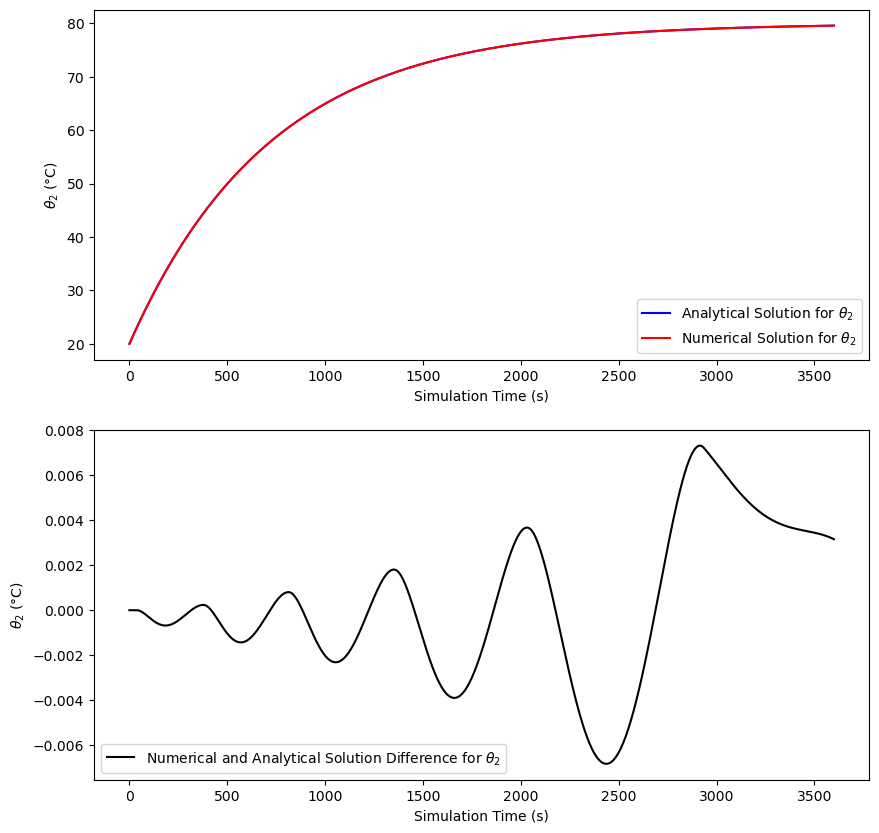

In [35]:
# Generation of plot of dependent variables against simulation time
plt.figure(figsize = (10, 10)) # Plot size

plt.subplot(211) # Assignment of plot space
plt.plot(t, theta2_AMT2, 'b', label = r"Analytical Solution for $\theta_{2}$") # Plot of Numerical theta1 against simulation time
plt.plot(t, theta2_AMT2_ODE, 'r', label = r"Numerical Solution for $\theta_{2}$") # Plot of Analytical theta1 against simulation time
plt.legend(loc = "lower right") # Plot legend location
plt.ylabel(r"$\theta_{2}$ ($\degree$C)")       # y-axis label of theta1 against simulation time
plt.xlabel("Simulation Time (s)") # x-axis label

plt.subplot(212)                  # Assignment of plot space to plot of theta1 against simulation time
plt.plot(t, theta2_AMT2-theta2_AMT2_ODE, 'k', label = r"Numerical and Analytical Solution Difference for $\theta_{2}$") # Plot of difference between numerical and analytical theta1 against simulation time
plt.legend(loc = "lower left") # Plot legend location
plt.ylabel(r"$\theta_{2}$ ($\degree$C)")       # y-axis label
plt.xlabel("Simulation Time (s)") # x-axis label

plt.show() # Display plot

Range of difference between theta2 values obtained via numerical and analytical solutions are very insignificant in magnitude and thus, ODE of theta2 is adequate to describe the system and is mathematically consistent and free from errors 

## 4.5. Model Checking: Analytical Method (C1)

Special Scenario - kref = 0 to uncouple theta1 from C1's ODE equation

### 4.5.1. Analytical Method (C1) System Inputs

In [37]:
# System Inputs (as per system inputs used for to generate experimental data modified for kref = 0)
M1_AMC1 = 300 # mass in CSTR 1 (kg)
M2_AMC1 = 500 # mass in CSTR 2 (kg) 
cp_AMC1 = 4182 # specific heat capacity of reactant (J/kg.degC) (Closely approximated by water)
thetahi_AMC1 = 80 # temperature of jacket fluid in (degC)
thetaF_AMC1 = 20 # temperature of feed fluid (degC)
E_AMC1 = 50887.87168 # activation energy (J/mol) (Determined as per derivations in sheet "kref and Ea" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
R_AMC1 = 8.314 # ideal gas constant (J/mol.K)
F_AMC1 = 16.7 / 60 # flowrate between CSTRs (kg/s)
q_AMC1 = 50 / 60 # flowrate of heating fluid in jackets (kg/s)
cph_AMC1 = 4182 # specific heat capacity of heating fluid (J/kg.degC) (heating fluid = water)
CF_AMC1 = 1.2 # feed concentration to CSTR 1 (mol/kg)
A1_AMC1 = 2.24683565 # Surface area of heat transfer between jacket 1 and CSTR1 (m^2) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
A2_AMC1 = 3.149478051 # Surface area of heat transfer between jacket 1 and CSTR1 (m^2) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
UA1_AMC1 = 4373.635737 # Average overall heat flux of jacket to CSTR1 (W/degC) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
UA2_AMC1 = 6180.284147 # Average overall heat flux of jacket to CSTR2 (W/degC) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
U1_AMC1 = UA1_AMC1 / A1_AMC1 # Overall heat transfer coefficient of jacket to CSTR1 (W/m^2.degC)
U2_AMC1 = UA2_AMC1 / A2_AMC1 # Overall heat transfer coefficient of jacket to CSTR1 (W/m^2.degC)
n_AMC1 = 1 # Order of reaction (unitless) (Determined as per derivations in sheet "kref and Ea" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
thetaref_AMC1 = 25 # Reference temperature for rate constant (degC)
kref_AMC1 = 0 # Rate constant at thetaref (s^-1) 

SI_AMC1 = (M1_AMC1, M2_AMC1, cp_AMC1, thetahi_AMC1, thetaF_AMC1, E_AMC1, R_AMC1, F_AMC1, q_AMC1, cph_AMC1, CF_AMC1, U1_AMC1, U2_AMC1, A1_AMC1, A2_AMC1, n_AMC1, thetaref_AMC1, kref_AMC1) # list of system inputs to be used as arguements for the defined ODE function

### 4.5.2. Analytical Method (C1) Generation

In [39]:
# C1 values based on analytical method
C1_AMC1 = [] # creation of list
for i in t:
    C1_AMC1_i = CF_AMC1 - (np.exp(-F_AMC1 / M1_AMC1 * i) * (CF_AMC1 - C1i)) # Analytical Solution for C1 at kref = 0
    C1_AMC1.append(C1_AMC1_i) # C1 analytical solution list

# Unpacking of dependent variables
dD_dt_AMC1 = solve_ivp(ODEs, [t_start,t_end], y0, t_eval = t, method = 'RK45', args = SI_AMC1) # Numerical solution of ODE with solve_ivp's 'RK45' method (Explicit Runge-Kutta method of order 5(4)) at a relative tolerance of 1e-3
C1_AMC1_ODE = dD_dt_AMC1.y[2] # assign item 2 to list C1

### 4.5.3. Model Checking: Analytical Method (C1) Visualisation

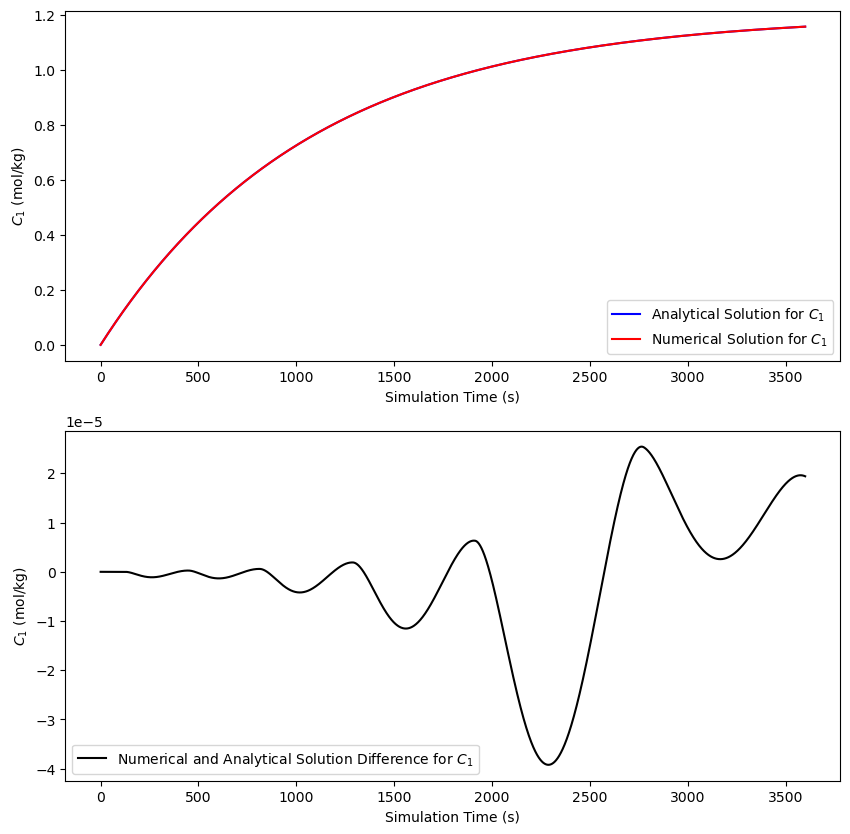

In [41]:
# Generation of plot of dependent variables against simulation time
plt.figure(figsize = (10, 10))    # Plot size

plt.subplot(211)                  # Assignment of plot space
plt.plot(t, C1_AMC1, 'b', label = r"Analytical Solution for $C_{1}$") # Plot of Analytical C1 against simulation time
plt.plot(t, C1_AMC1_ODE, 'r', label = r"Numerical Solution for $C_{1}$") # Plot of Numerical C1 against simulation time
plt.legend(loc = "lower right") # Plot legend location
plt.ylabel("$C_{1}$ (mol/kg)")       # y-axis label
plt.xlabel("Simulation Time (s)") # x-axis label

plt.xlabel("Simulation Time (s)") # x-axis label of theta1 against simulation time
plt.subplot(212)                  # Assignment of plot space to plot of theta1 against simulation time
plt.plot(t, C1_AMC1-C1_AMC1_ODE, 'k', label = r"Numerical and Analytical Solution Difference for $C_{1}$") # Plot of theta1 against simulation time
plt.legend(loc = "lower left") # Plot legend location
plt.ylabel("$C_{1}$ (mol/kg)")       # y-axis label of theta1 against simulation time
plt.xlabel("Simulation Time (s)") # x-axis label of theta1 against simulation time

plt.show()                        # Display plot

Range of difference between C1 values obtained via numerical and analytical solutions are very insignificant in magnitude and thus, ODE of C1 is adequate to describe the system and is mathematically consistent and free from errors 

## 4.6. Model Checking: Analytical Method (C2)

Special Scenario - kref = 0 to uncouple theta2 from C2's ODE equation

### 4.6.1. Analytical Method (C2) System Inputs

In [43]:
# System Inputs (as per system inputs used for to generate experimental data modified for F = 0)
M1_AMC2 = 300 # mass in CSTR 1 (kg)
M2_AMC2 = 500 # mass in CSTR 2 (kg) 
cp_AMC2 = 4182 # specific heat capacity of reactant (J/kg.degC) (Closely approximated by water)
thetahi_AMC2 = 80 # temperature of jacket fluid in (degC)
thetaF_AMC2 = 20 # temperature of feed fluid (degC)
E_AMC2 = 50887.87168 # activation energy (J/mol) (Determined as per derivations in sheet "kref and Ea" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
R_AMC2 = 8.314 # ideal gas constant (J/mol.K)
F_AMC2 = 16.7 / 60 # flowrate between CSTRs (kg/s)
q_AMC2 = 50 / 60 # flowrate of heating fluid in jackets (kg/s)
cph_AMC2 = 4182 # specific heat capacity of heating fluid (J/kg.degC) (heating fluid = water)
CF_AMC2 = 1.2 # feed concentration to CSTR 1 (mol/kg)
A1_AMC2 = 2.24683565 # Surface area of heat transfer between jacket 1 and CSTR1 (m^2) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
A2_AMC2 = 3.149478051 # Surface area of heat transfer between jacket 1 and CSTR1 (m^2) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
UA1_AMC2 = 4373.635737 # Average overall heat flux of jacket to CSTR1 (W/degC) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
UA2_AMC2 = 6180.284147 # Average overall heat flux of jacket to CSTR2 (W/degC) (Determined as per derivations in sheet "UA" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
U1_AMC2 = UA1_AMC1 / A1_AMC1 # Overall heat transfer coefficient of jacket to CSTR1 (W/m^2.degC)
U2_AMC2 = UA2_AMC1 / A2_AMC1 # Overall heat transfer coefficient of jacket to CSTR1 (W/m^2.degC)
n_AMC2 = 1 # Order of reaction (unitless) (Determined as per derivations in sheet "kref and Ea" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")
thetaref_AMC2 = 25 # Reference temperature for rate constant (degC)
kref_AMC2 = 0 # Rate constant at thetaref (s^-1) (Determined as per derivations in sheet "kref and Ea" of the attached excel file "Validation data for two CSTR reactors in series - FTE3014 Modelling assignment part B")

SI_AMC2 = (M1_AMC2, M2_AMC2, cp_AMC2, thetahi_AMC2, thetaF_AMC2, E_AMC2, R_AMC2, F_AMC2, q_AMC2, cph_AMC2, CF_AMC2, U1_AMC2, U2_AMC2, A1_AMC2, A2_AMC2, n_AMC2, thetaref_AMC2, kref_AMC2) # list of system inputs to be used as arguements for the defined ODE function

### 4.6.2. Analytical Method (C2) Generation

In [45]:
# C1 values based on analytical method
C2_AMC2 = [] # Creation of list
for i in t:
    C2_AMC2_i = CF_AMC2 - ((F_AMC2 / M2_AMC2) * ((F_AMC2 / M2_AMC2 - F_AMC2 / M1_AMC2) ** -1) * (CF_AMC2 -C1i) * np.exp(-F_AMC2 / M1_AMC2 * i)) - 3 * np.exp(-F_AMC2 / M2_AMC2 * i) # Analytical Solution for C2 at kref = 0
    C2_AMC2.append(C2_AMC2_i) # C1 analytical solution list

# Unpacking of dependent variables
dD_dt_AMC2 = solve_ivp(ODEs, [t_start,t_end], y0, t_eval = t, method = 'RK45', args = SI_AMC2) # Numerical solution of ODE with solve_ivp's 'RK45' method (Explicit Runge-Kutta method of order 5(4)) at a relative tolerance of 1e-3
C2_AMC2_ODE = dD_dt_AMC2.y[3] # assign list item 2 to list C2

### 4.6.3. Model Checking: Analytical Method (C2) Visualisation

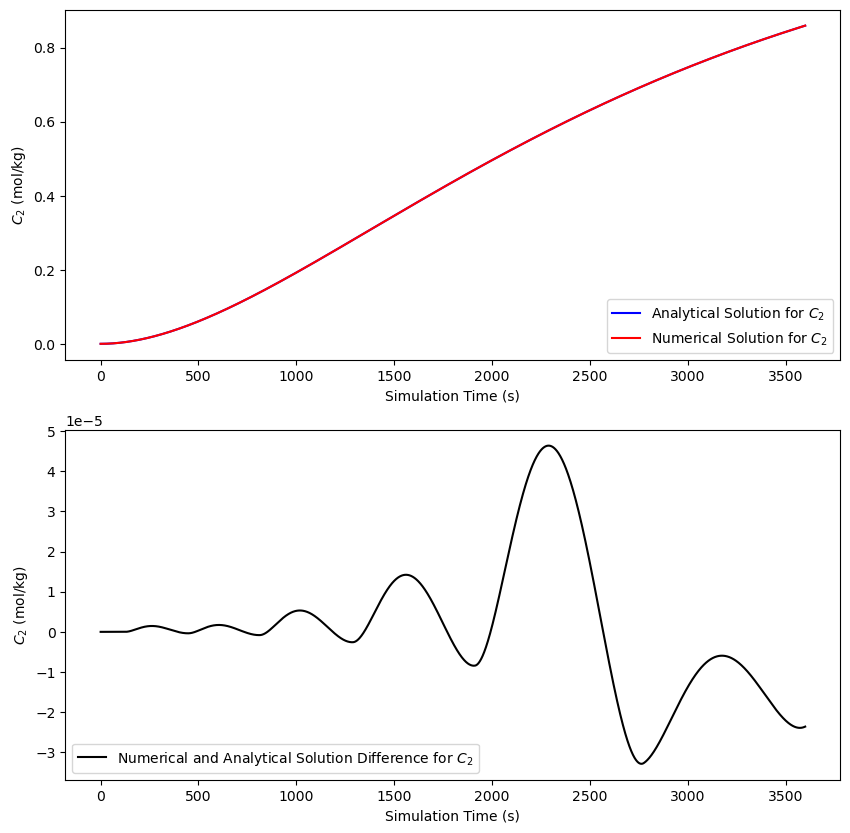

In [47]:
# Generation of plot of dependent variables against simulation time
plt.figure(figsize = (10, 10)) # Plot size

plt.subplot(211) # Assignment of plot space
plt.plot(t, C2_AMC2, 'b', label = r"Analytical Solution for $C_{2}$") # Plot of Analytical C2 against simulation time
plt.plot(t, C2_AMC2_ODE, 'r', label = r"Numerical Solution for $C_{2}$") # Plot of Numerical C2 against simulation time
plt.legend(loc = "lower right") # Plot legend location
plt.ylabel("$C_{2}$ (mol/kg)") # y-axis label
plt.xlabel("Simulation Time (s)") # x-axis label

plt.subplot(212) # Assignment of plot space 
plt.plot(t, C2_AMC2-C2_AMC2_ODE, 'k', label = r"Numerical and Analytical Solution Difference for $C_{2}$") # Plot of difference between analytical and numerical C2 against simulation time
plt.legend(loc = "lower left") # Plot legend location
plt.ylabel("$C_{2}$ (mol/kg)") # y-axis label
plt.xlabel("Simulation Time (s)") # x-axis label 

plt.show() # Display plot

Range of difference between C2 values obtained via numerical and analytical solutions are very insignificant in magnitude and thus, ODE of C2 is adequate to describe the system and is mathematically consistent and free from errors 

# 5 Model Validation: Sensitivity Analysis

## 5.1. Validation Data: + Value System Inputs

In [49]:
# Validation Data System Inputs (+ Values)
M1_F = 300 * (1 + 0.01) # mass in CSTR 1 (kg)
M2_F = 500 * (1 + 0.01) # mass in CSTR 2 (kg)
thetahi_F = 80 + 0.49 # temperature of jacket fluid in (degC)
thetaF_F = 20 * (1 + 0.005) # temperature of feed fluid (degC)
F_F = 16.7 / 60 * (1 + 0.02) # flowrate between CSTRs (kg/s)
q_F = 50 / 60 * (1 + 0.02) # flowrate of heating fluid in jackets (kg/s)
CF_F = 1.2 * (1 + 0.02) # feed concentration to CSTR 1 (mol/kg)
A1_F = 2.255854534 # Jacket 1 internal heat transfer area (m^2)
A2_F = 3.160155696 # Jacket 2 internal heat transfer area (m^2)
UA1_F = 4876.688718 # Average overall heat flux of jacket to CSTR1 (W/degC)
UA2_F = 7267.320389 # Average overall heat flux of jacket to CSTR2 (W/degC)
U1_F = UA1_F / A1_F # overall heat transfer coefficient of jacket to CSTR 1 (W/m^2.degC)
U2_F = UA2_F / A2_F # overall heat transfer coefficient of jacket to CSTR 2 (W/m^2.degC)

## 5.2. Validation Data: - Values System Inputs

In [51]:
# Validation Data System Inputs (- Values)
M1_S = 300 * (1 - 0.01) # mass in CSTR 1 (kg)
M2_S = 500 * (1 - 0.01) # mass in CSTR 2 (kg)
thetahi_S = 80 - 0.49 # temperature of jacket fluid in (degC)
thetaF_S = 20 * (1 - 0.005) # temperature of feed fluid (degC)
F_S = 16.7 / 60 * (1 - 0.02) # flowrate between CSTRs (kg/s)
q_S = 50 / 60 * (1 - 0.02) # flowrate of heating fluid in jackets (kg/s)
CF_S = 1.2 * (1 - 0.02) # feed concentration to CSTR 1 (mol/kg)
A1_S = 2.237834359 # Jacket 1 internal heat transfer area (m^2)
A2_S = 3.138817999 # Jacket 2 internal heat transfer area (m^2)
UA1_S = 3920.450696 # Average overall heat flux of jacket to CSTR1 (W/degC)
UA2_S = 5710.385557 # Average overall heat flux of jacket to CSTR2 (W/degC)
U1_S = UA1_S / A1_S # overall heat transfer coefficient of jacket to CSTR 1 (W/m^2.degC)
U2_S = UA2_S / A2_S # overall heat transfer coefficient of jacket to CSTR 2 (W/m^2.degC)

## 5.3. Model Validation: Numerical Solution at Extreme System Inputs

In [53]:
# Numerical Solution at extreme SI situations
SI_theta1_F = (M1_S, M2_S, cp, thetahi_F, thetaF_F, E, R, F_S, q_F, cph, CF, U1_F, U2_S, A1_F, A2_S, n, thetaref, kref)
dD_dt_theta1_F = solve_ivp(ODEs, [t_start,t_end], y0, t_eval = t, method = 'RK45', args = SI_theta1_F) # Numerical solution of ODE with solve_ivp's 'RK45' method (Explicit Runge-Kutta method of order 5(4)) at a relative tolerance of 1e-3
theta1_F = dD_dt_theta1_F.y[0] # list of numerical theta1 at fast change

SI_theta1_S = (M1_F, M2_F, cp, thetahi_S, thetaF_S, E, R, F_F, q_S, cph, CF, U1_S, U2_F, A1_S, A2_F, n, thetaref, kref)
dD_dt_theta1_S = solve_ivp(ODEs, [t_start,t_end], y0, t_eval = t, method = 'RK45', args = SI_theta1_S) # Numerical solution of ODE with solve_ivp's 'RK45' method (Explicit Runge-Kutta method of order 5(4)) at a relative tolerance of 1e-3
theta1_S = dD_dt_theta1_S.y[0] # list of numerical theta1 at slow change

SI_theta2_F = (M1_S, M2_S, cp, thetahi_F, thetaF_F, E, R, F_S, q_F, cph, CF, U1_F, U2_F, A1_F, A2_F, n, thetaref, kref)
dD_dt_theta2_F = solve_ivp(ODEs, [t_start,t_end], y0, t_eval = t, method = 'RK45', args = SI_theta2_F) # Numerical solution of ODE with solve_ivp's 'RK45' method (Explicit Runge-Kutta method of order 5(4)) at a relative tolerance of 1e-3
theta2_F = dD_dt_theta2_F.y[1] # list of numerical theta2 at fast change

SI_theta2_S = (M1_F, M2_F, cp, thetahi_S, thetaF_S, E, R, F_F, q_S, cph, CF, U1_S, U2_S, A1_S, A2_S, n, thetaref, kref)
dD_dt_theta2_S = solve_ivp(ODEs, [t_start,t_end], y0, t_eval = t, method = 'RK45', args = SI_theta2_S) # Numerical solution of ODE with solve_ivp's 'RK45' method (Explicit Runge-Kutta method of order 5(4)) at a relative tolerance of 1e-3
theta2_S = dD_dt_theta2_S.y[1] # list of numerical theta2 at slow change

SI_C1_F = (M1_S, M2_F, cp, thetahi_S, thetaF_S, E, R, F_F, q_S, cph, CF_F, U1_S, U2_F, A1_S, A2_F, n, thetaref, kref)
dD_dt_C1_F = solve_ivp(ODEs, [t_start,t_end], y0, t_eval = t, method = 'RK45', args = SI_C1_F) # Numerical solution of ODE with solve_ivp's 'RK45' method (Explicit Runge-Kutta method of order 5(4)) at a relative tolerance of 1e-3
C1_F = dD_dt_C1_F.y[2] # list of numerical C1 at fast change

SI_C1_S = (M1_F, M2_S, cp, thetahi_F, thetaF_F, E, R, F_S, q_F, cph, CF_S, U1_F, U2_S, A1_F, A2_S, n, thetaref, kref)
dD_dt_C1_S = solve_ivp(ODEs, [t_start,t_end], y0, t_eval = t, method = 'RK45', args = SI_C1_S) # Numerical solution of ODE with solve_ivp's 'RK45' method (Explicit Runge-Kutta method of order 5(4)) at a relative tolerance of 1e-3
C1_S = dD_dt_C1_S.y[2] # list of numerical C1 at slow change

SI_C2_F = (M1_S, M2_S, cp, thetahi_S, thetaF_S, E, R, F_F, q_S, cph, CF_F, U1_S, U2_S, A1_S, A2_S, n, thetaref, kref)
dD_dt_C2_F = solve_ivp(ODEs, [t_start,t_end], y0, t_eval = t, method = 'RK45', args = SI_C2_F) # Numerical solution of ODE with solve_ivp's 'RK45' method (Explicit Runge-Kutta method of order 5(4)) at a relative tolerance of 1e-3
C2_F = dD_dt_C2_F.y[3] # list of numerical C2 at fast change

SI_C2_S = (M1_F, M2_F, cp, thetahi_F, thetaF_F, E, R, F_S, q_F, cph, CF_S, U1_F, U2_F, A1_F, A2_F, n, thetaref, kref)
dD_dt_C2_S = solve_ivp(ODEs, [t_start,t_end], y0, t_eval = t, method = 'RK45', args = SI_C2_S) # Numerical solution of ODE with solve_ivp's 'RK45' method (Explicit Runge-Kutta method of order 5(4)) at a relative tolerance of 1e-3
C2_S = dD_dt_C2_S.y[3] # list of numerical C2 at slow change

## 5.4. Model Validation: R2 Score

In [55]:
#R^2 analysis for theta1 between numerical and analytical solutions
corr_matrix_theta1 = np.corrcoef(theta1_exp, theta1[::60])
corr_theta1 = corr_matrix_theta1[0,1]
Rsq_theta1 = corr_theta1 ** 2


#R^2 analysis for theta2 between numerical and analytical solutions
corr_matrix_theta2 = np.corrcoef(theta2_exp, theta2[::60])
corr_theta2 = corr_matrix_theta2[0,1]
Rsq_theta2 = corr_theta2 ** 2


#R^2 analysis for C1 between numerical and analytical solutions
corr_matrix_C1 = np.corrcoef(C1_exp, C1[::60])
corr_C1 = corr_matrix_C1[0,1]
Rsq_C1 = corr_C1 ** 2


#R^2 analysis for C2 between numerical and analytical solutions
corr_matrix_C2 = np.corrcoef(C2_exp, C2[::60])
corr_C2 = corr_matrix_C2[0,1]
Rsq_C2 = corr_C2 ** 2

print("theta 1 r2 score:", round(Rsq_theta1, 3))
print("theta 2 r2 score:", round(Rsq_theta2, 3))
print("C1 r2 score: \t ", round(Rsq_C1, 3))
print("C2 r2 score: \t ", round(Rsq_C2, 3))

theta 1 r2 score: 0.999
theta 2 r2 score: 0.999
C1 r2 score: 	  0.968
C2 r2 score: 	  0.928


Very high r2 scores of all 4 ODEs indicates that ODEs are able to model the parallel CSTR system with high accuracy

## 5.5. Model Validation: Fit Visualisation

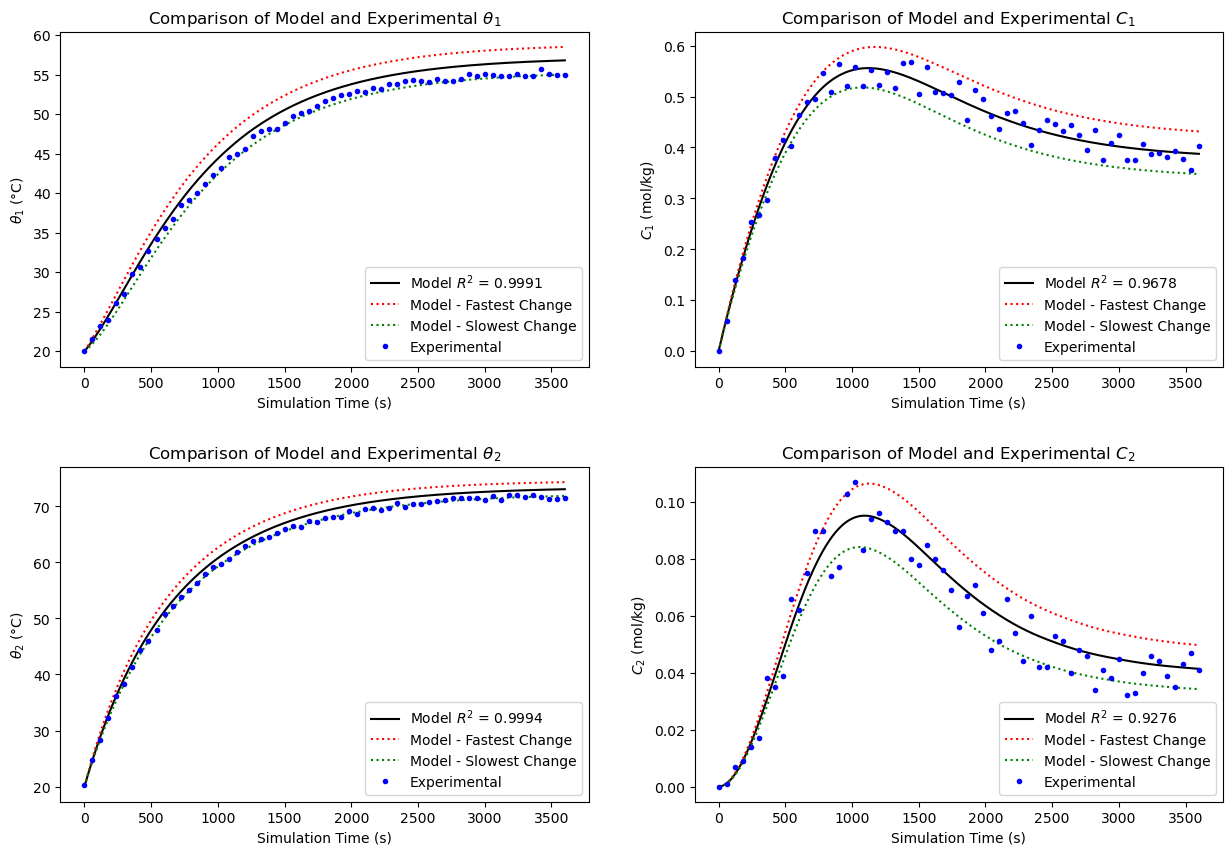

In [57]:
# Generation of plot of dependent variables against simulation time
plt.figure(figsize = (15, 10)) # Plot size
plt.subplots_adjust(hspace = 0.3) # Adjust height interval between plots to adequately display x-axis titles

plt.subplot(221) # Assignment of top-left space 
plt.title(r"Comparison of Model and Experimental $\theta_{1}$") # Plot title
plt.plot(t, theta1, 'k', label = r"Model $R^{2}$ = " + str(round(Rsq_theta1,4))) # Plot of numerical theta1 against simulation time
plt.plot(t, theta1_F, 'r:', label = "Model - Fastest Change") # Plot of fast numerical theta1 against simulation time
plt.plot(t, theta1_S, 'g:', label = "Model - Slowest Change") # Plot of slow numerical theta1 against simulation time
plt.plot(t_exp, theta1_exp, 'b.', label = "Experimental") # Plot of experimental theta1 against simulation time
plt.legend(loc="lower right") # Plot legend location
plt.ylabel(r"$\theta_{1}$ ($\degree$C)") # y-axis label
plt.xlabel("Simulation Time (s)") # x-axis label

plt.subplot(222) # Assignment of top-right space
plt.title(r"Comparison of Model and Experimental $C_{1}$") # Plot title
plt.plot(t, C1, 'k', label = r"Model $R^{2}$ = " + str(round(Rsq_C1,4))) # Plot of numerical C1 against simulation time
plt.plot(t, C1_F, 'r:', label = "Model - Fastest Change") # Plot of fast numerical C1 against simulation time
plt.plot(t, C1_S, 'g:', label = "Model - Slowest Change") # Plot of slow numerical C1 against simulation time
plt.plot(t_exp, C1_exp, 'b.', label = "Experimental")
plt.legend(loc="lower right") # Plot legend location
plt.ylabel("$C_{1}$ (mol/kg)") # y-axis label
plt.xlabel("Simulation Time (s)") # x-axis label

plt.subplot(223) # Assignment of bottom-left space to plot of theta2 against simulation time
plt.title(r"Comparison of Model and Experimental $\theta_{2}$") # Plot title
plt.plot(t, theta2, 'k', label = r"Model $R^{2}$ = " + str(round(Rsq_theta2,4))) # Plot of numerical theta2 against simulation time
plt.plot(t,theta2_F, 'r:', label = "Model - Fastest Change") # Plot of fast numerical theta2 against simulation time
plt.plot(t, theta2_S, 'g:', label = "Model - Slowest Change") # Plot of slow numerical theta2 against simulation time
plt.plot(t_exp, theta2_exp, 'b.', label = "Experimental")
plt.legend(loc="lower right") # Plot legend location
plt.ylabel(r"$\theta_{2}$ ($\degree$C)") # y-axis
plt.xlabel("Simulation Time (s)") # x-axis label

plt.subplot(224) # Assignment of bottom-right space to plot of C1 against simulation time
plt.title(r"Comparison of Model and Experimental $C_{2}$") # Plot title
plt.plot(t, C2, 'k', label = r"Model $R^{2}$ = " + str(round(Rsq_C2,4))) # Plot of numerical C2 against simulation time
plt.plot(t, C2_F, 'r:', label = "Model - Fastest Change") # Plot of fast numerical C2 against simulation time
plt.plot(t, C2_S, 'g:', label = "Model - Slowest Change") # Plot of slow numerical C2 against simulation time
plt.plot(t_exp, C2_exp, 'b.', label = "Experimental")
plt.legend(loc="lower right") # Plot legend location
plt.ylabel("$C_{2}$ (mol/kg)") # y-axis label
plt.xlabel("Simulation Time (s)") # x-axis label

plt.show() # Display plot

While the numerical solutions of θ1 and θ2 is shaped closely 
to that of the experimental data, the numerical solutions of both temperatures appear to be
slightly higher than that of the experimental data at all time points within the simulation. Ththe difference is likely due to te 
assumption made for the model that heat loss is negligi

Despite the numerical solution of C1 visually appearing to be close fit to the experimental data 
in terms of its general shap3, therR2 value is at 0.962 indicating that while the
model is of a good fit to the experimental data, there is slight variability. This slight variabilit 
is likely as a result of the spread of the experimental data. One possible cause for this lare 
spread of data could be due to the requirement for a greater number of system inputs in he 
ODE that affects the respo1 that translates to a greater degree of uncertainty.

The numerical solution for C2 visually appears to be slightly flatter and less sinusoidal as 
compared to the shape produced by the experimental dat3, the
numerical solution at t = 1000 s appears lower than the average of the experimental data, an 
from t = 1500 s onwards appears higher than the average of the experimental data. This possiby 
indicates that the developed model for C2 may require modification to more appropriatly 
describe and model the system. One possible reason for the varied C2 experimental dat as 
compared to the experimental data is that several of the system inputs were assume and 
estimated without any uncertainty values and may not be the most accurate value of a ystem 
input to analyze the general model. One example of such system input includes the assmption 
that the rate order of this reaction is exactly 1 which resulted in the higher C2 of the numerical 
solution after t = 1500 s when it is possible that the rate order is slightly le 
Table 1, can possibly bring the higher numerical solution closer to experimental data.ble 1ble.